# EEWeather international: summary with tutorial 

## Description

Having been developed for the US market, there has until now been no need for an EEWeather module to call air temperature data outside of that region. Open Energy Efficiency Savings (OpenEnEffS) has developed an extension to EEWeather allowing for air temperature calls from anywhere in the world using the European Centre for Medium Range Weather Forecasts (EMCWF)'s Climate Data Store (CDS) API. This temperature data is licensed on a free-to-use and reproduce basis, but remains the property of ECMWF and the European Union.
    
This extension can source Celsius air temperature at 2m height for anywhere in the world given a area specification code such as a postcode/zipcode. This opens up EEWeather to locations outside of the United States, which it is currently unable to do.

EEWeather international exists as a complement to EEMeter international, a set of amendments to the EEMeter package design to open up the CalTRACK Methods to markets outside of the United States.

EEWeather international was developed by Carbon Co-op and enabled by Innovate UK grant number 10032096 in 2022. Carbon Co-op is a membership-based energy services co-operative in Manchester, UK. Innovate UK is the UK's national innovation agency and an agency of the UK Government.

## Requirements

Use of EEWeather international requires all users to create a CDS account and agree to the terms of the Copernicus licence associated with ERA5 reanalysis data. As of February 2023, this licence allows for the distribution of data on a free of charge, worldwide, non-exclusive, royalty free and perpetual basis, provided that both the Copernicus programme and European Union are clearly attributed.

New users can create a CDS account [here](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome).

Users can check the progress of weather calls [here](https://cds.climate.copernicus.eu/cdsapp#!/yourrequests).

Technical notes (as detailed in lines 251-267 of `eeweather.international.py`) are as follows: 

    TECHNICAL NOTES

    1. Use of the CDS API requires all users to set up a CDS account and agree to the terms of the CDS licence,
    linked above.
    2. Users may also be required to set up the CDS API key and install a .cdsapirc file, in their home
    directory, guidance on which is available at: https://cds.climate.copernicus.eu/api-how-to.
    3. Users may be required to install the eccodes library, used for the interpretation of GRIB weather files.
        3a. This package has been designed for Linux systems, on which it can be installed using the following link:
        https://confluence.ecmwf.int/display/ECC/Releases; alternatively eccodes can be installed on Python 3 using
        pip3 install eccodes.
        3b. For Windows users, eccodes and the related Magics package can be installed with conda using
        conda install -c conda-forge eccodes Magics. Further details available at:
        https://www.ecmwf.int/en/newsletter/159/news/eccodes-and-magics-available-under-windows
    4. The cfgrib package is also required for the functioning of this package. If not already installed, users should
    install cfgrib via pip install cfgrib==0.8.4.5. Details available at: https://pypi.org/project/cfgrib/0.8.4.5/

    To check the progress of your download, visit: https://cds.climate.copernicus.eu/cdsapp#!/yourrequests

## Performance

### 1. Accuracy: CDS vs. existing EEWeather data
   
The advantage of using the CDS API in the United States over 'original' EEWeather is that the while the original package relies on a network of weather stations, there can be significant variance between sites concerned and the nearest weather station. **Figure 1** illustrates the variance in distance of weather stations from sites for the existing EEWeather package, with the distance from site distribution for the CDS overlaid. The CDS extension allows for external temperature to be called to a bounding box of precision 0.25 decimal degrees (approximately 27.75x27.75km) for each given areacode. This means that each site is consistently matched to weather data of no more than 14km distance from the given areacode and mean 7km.

In [1]:
import eemeter
import eeweather
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.formula.api as smf
import scipy
from pathlib import Path
matplotlib.rcParams['figure.dpi'] = 250

In [2]:
def eeweather_run(latitude, longitude):
    ranked_stations_closest_within_climate_zone = eeweather.rank_stations(
        latitude,
        longitude,
        match_iecc_climate_zone=True,
        match_iecc_moisture_regime=True,
        match_ba_climate_zone=True,
        match_ca_climate_zone=True,
        max_distance_meters=100000,
    )

    ranked_stations_closest_anywhere = eeweather.rank_stations(
        latitude,
        longitude,
    )

    ranked_stations = eeweather.combine_ranked_stations([
        ranked_stations_closest_within_climate_zone,
        ranked_stations_closest_anywhere,
    ])
    return ranked_stations

fake = Faker()
Faker.seed(0)

lat_log = []
boundingbox = []

counter = 0 ;
countries = ['US'] 
total = 1000
size = total / len(countries) -1
country = -1
for _ in range(total):
    if counter >= size:
        counter =0
        country = country + 1
    unit = list(fake.local_latlng(country_code= countries[country]))
    boundingbox = [
        float(unit[0]) - 0.16,
        float(unit[0]) + 0.16,
        float(unit[1]) - 0.16,
        float(unit[1]) + 0.16,
    ]
    for i in boundingbox:
        unit.append(i)
    lat_log.append(unit)
    counter = counter + 1

df = pd.DataFrame(lat_log)

distance_list = []
progress = list(range(0,1000))
for latitude, longitude, progress in zip(df[0], df[1], progress):
    latitude = float(latitude)
    longitude = float(longitude)
    min_distance = eeweather_run(latitude, longitude)['distance_meters'].min()
    distance_list.append(min_distance)

df['Minimum distance'] = distance_list

### 2. Temperature values variance

Temperature data sourced via the CDS API for United States locations returns values of minimal deviation from 'original' EEWeather values for given sites. Across 100 randomly sourced United States locations, the average difference between CDS and 'original' EEWeather corresponds to **0.136** degrees Celsius, with a very small variance corresponding to a standard error of **0.002**, as demonstrated in **Figure 2**. Use of the CDS therefore ought to return similar savings figures to the use of EEWeather for any given consumption dataset.

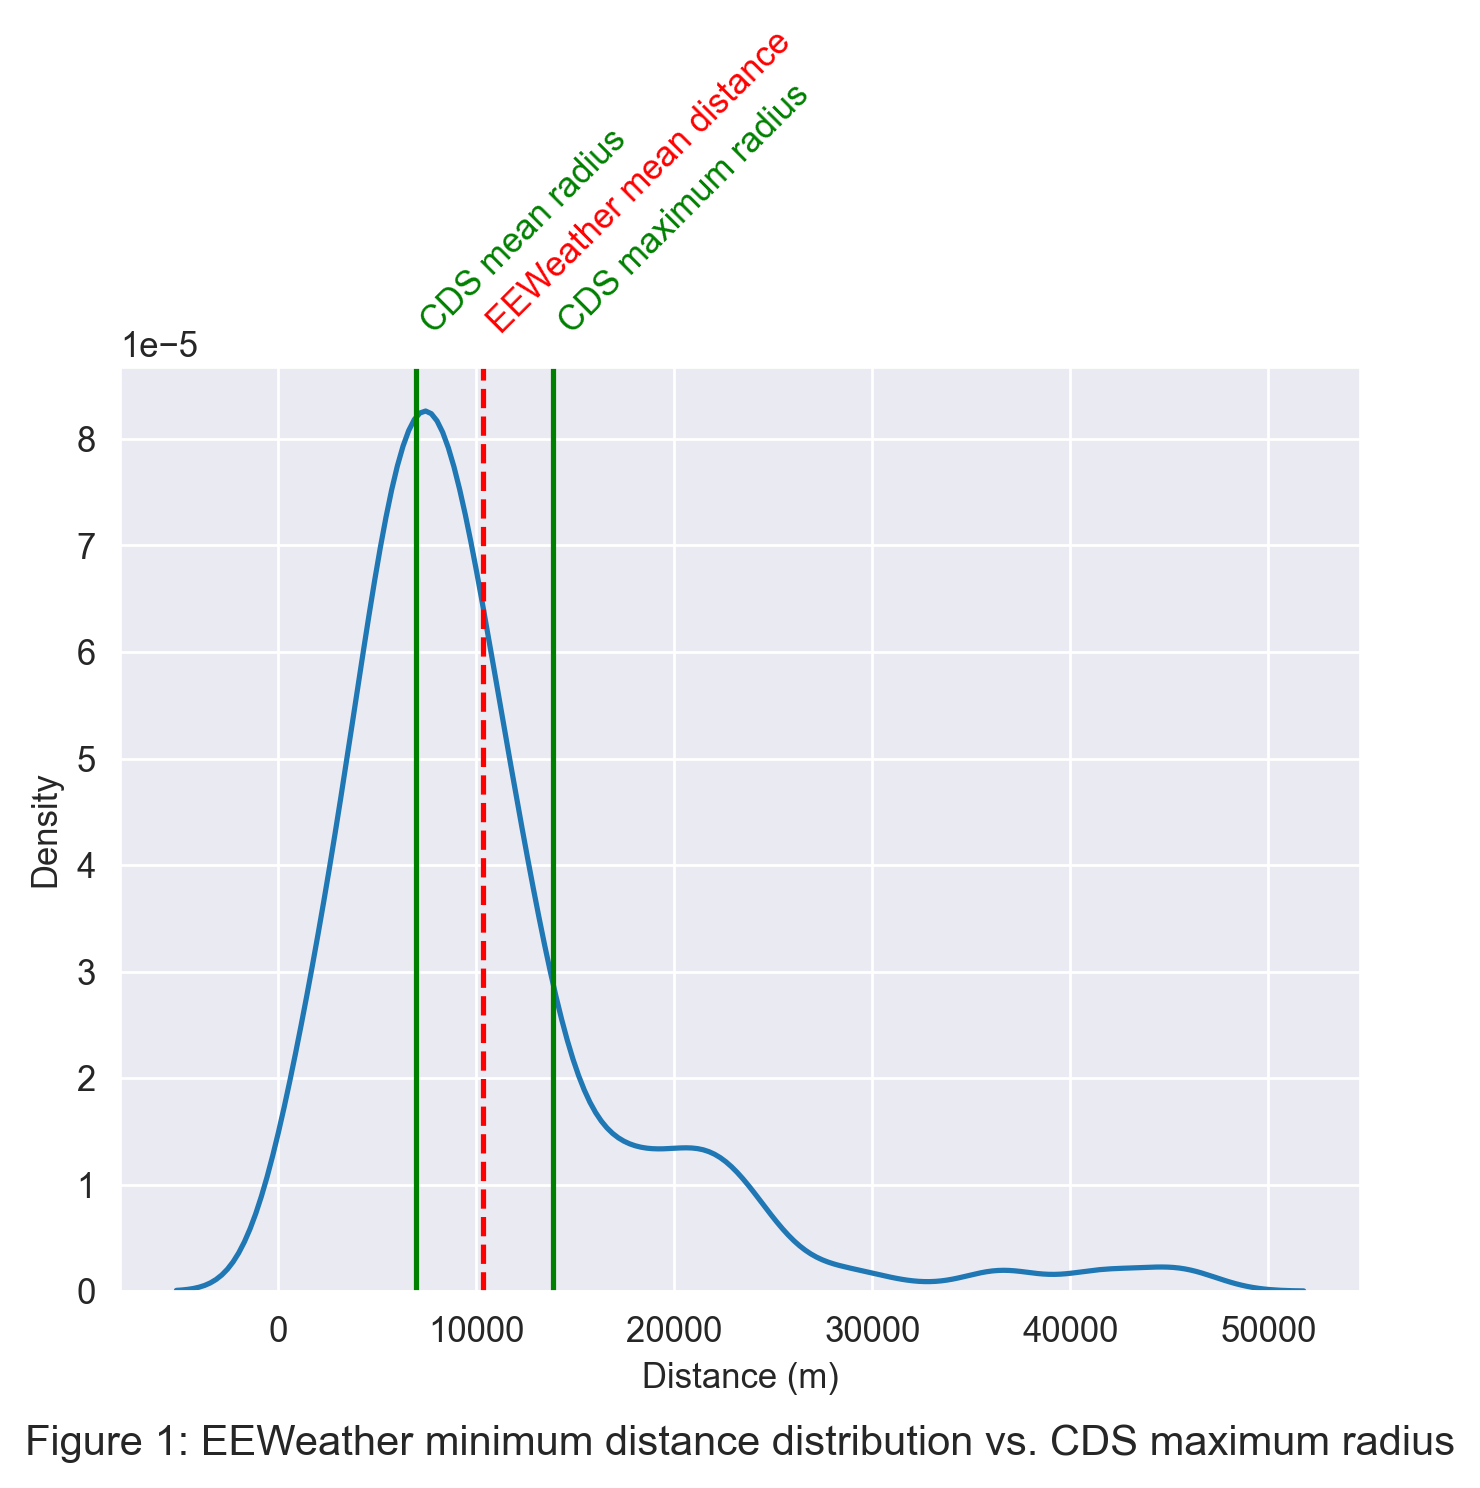

EEWeather mean distance: 10319m
EEWeather median distance: 8412m
EEWeather standard deviation: 7725m
CDS maximum radius: 16000m


In [3]:
sns.set_style('darkgrid')
sns.kdeplot(df['Minimum distance'])
plt.axvline(x=df['Minimum distance'].mean(), color='r', linestyle='dashed')
plt.text(
    df['Minimum distance'].mean(),
    0.00009,
    'EEWeather mean distance',
    rotation=45,
    color='r',
)


plt.axvline(x=13875, color='g')
plt.text(
    13875,
    0.00009,
    'CDS maximum radius',
    rotation=45,
    color='g',
)

plt.axvline(x=6938, color='g')
plt.text(
    6938,
    0.00009,
    'CDS mean radius',
    rotation=45,
    color='g',
)

plt.title('Figure 1: EEWeather minimum distance distribution vs. CDS maximum radius', y=-.2)
plt.xlabel('Distance (m)')
plt.show()

print('EEWeather mean distance: ' + str(int(df['Minimum distance'].mean()))+ 'm')
print('EEWeather median distance: ' + str(int(df['Minimum distance'].median()))+ 'm')
print('EEWeather standard deviation: ' + str(int(df['Minimum distance'].std()))+ 'm')
print('CDS maximum radius: 16000m')

In [4]:
len(distance_list)

1000

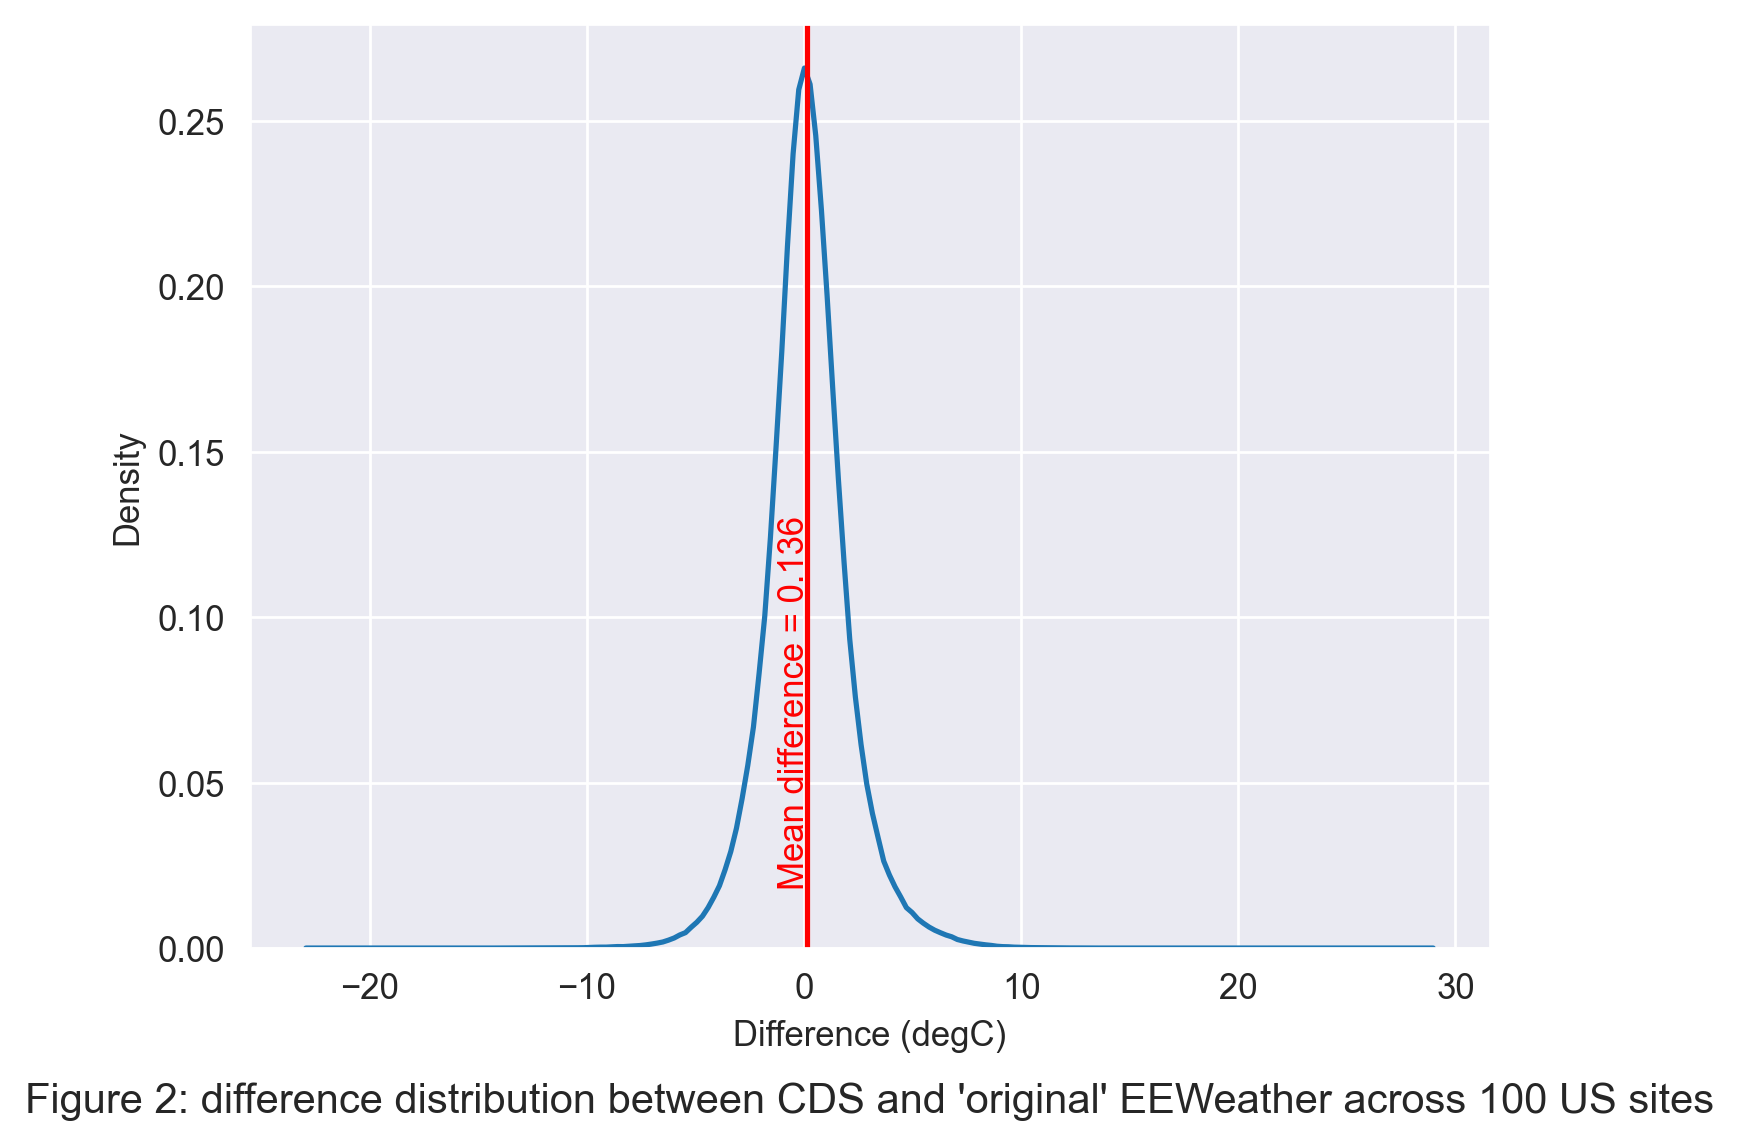

Group mean: 0.136
Standard error: 0.002


In [5]:
p = Path().resolve().parents[0]

diff_list = []

for i in list(range(100)):
    control = pd.read_csv(str(p) + '/samples/intl_samples/' + str(i) + '_control.csv', index_col=0)
    control = control.rename(columns={'0': 'Control'})
    control.index = pd.to_datetime(control.index)
    test = pd.read_csv(str(p) + '/samples/intl_samples/' + str(i) + '.csv', index_col=0)
    test = test.rename(columns={'temp':'Test'})
    test.index = pd.to_datetime(test.index)
    diff = list(control['Control']-test['Test'])
    for j in diff:
        diff_list.append(j)

diff = pd.DataFrame(index=range(len(diff_list)), data=diff_list).dropna()

sns.set_style('darkgrid')
sns.kdeplot(data=diff, x=diff[0])
plt.axvline(np.mean(diff[0]), color='r')
plt.text(
    np.mean(diff[0])+0.2,
    0.02,
    'Mean difference = ' + str(round(np.mean(diff[0]), 3)),
    rotation=90,
    color='r',
    horizontalalignment='right'
)
plt.xlabel('Difference (degC)')
plt.title("Figure 2: difference distribution between CDS and 'original' EEWeather across 100 US sites", y=-.2)
plt.show()

print('Group mean: ' + str(round(np.mean(diff[0]), 3)))
print('Standard error: ' + str(round(scipy.stats.sem(diff[0]), 3)))

### 3. Speed

While outputs from the EEWeather international package (via CDS) are accurate, API traffic on the CDS means that download speeds are poor compared to 'original' EEWeather. A typical 2-year interval call for US sites using the 'original' package can be expected to return temperature data at a mean of 0.12 seconds; the same call using EEWeather international might typically take __552 seconds__. 

Users in the United States should therefore continue to use 'original' EEWeather.

Users seeking to use EEWeather outside of the United States (in combination with EEMeter international) should plan in advance to save weather files locally to avoid repetition. Where portfolios of multiple sites are concerned, users can make use of the `get_weather_intervals_for_similar_sites` function described below.

<u> Operation of the CDS <u/>

The CDS uses a queue to handle traffic. EEWeather international calls are automatically placed in the queue; once approved a download will begin. Since the CDS assigns small-volume calls higher priority in the queue, EEWeather operates by making requests on a month-by-month basis. This means that for a request of January - April, CDS will be asked for January's, February's, March's and April's data in turn.
    
Further details on the queue, including [queue times by request size](https://eqc.climate.copernicus.eu/monitoring#highlevel_view;year) and [KPIs](https://cds.climate.copernicus.eu/live/priorities), can be found [here](https://cds.climate.copernicus.eu/live/queue).

### Portfolio weather calls - efficient handling of the CDS
In circumstances where weather data is required for portfolios of sites, it is possible that groups of sites will fall into the same reference grid used to pull data from the CDS. Whereas 'original' EEWeather operates on a discrete basis i.e. the package will call as many weather datasets as sites, irrespective of possible duplication, performance constraints on the CDS have required the development of an alternative approach. EEWeather international can identify unique sites to a precision of 0.25 decimal degrees (the same precision as ERA5 2m temperature data from the CDS) and make a single call for a group of sites in the same reference area corresponding to the first and the latest chronological points required for all calls. The resulting CSV file can then be saved and individual 'per-site' slices of weather data extracted.

This facility is available via the `get_weather_intervals_for_similar_sites` function. In order for this function to work, data must be formatted into categories of start_date, end_date, latitude and longitude for each site. This format is detailed below.

In [6]:
df = pd.read_csv(str(p) + "/samples/intl_samples/df.csv", index_col=0).dropna()

#NOTE start_date and end_date must be pd.datetime
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df.head()

,start_date,end_date,latitude,longitude
0,2018-04-10,2022-12-22 12:10:30.014357,53.50,-2.25
1,2018-06-29,2022-12-22 12:10:30.014357,53.50,-2.00
2,2019-08-19,2022-12-22 12:10:30.014357,53.50,-1.75
3,2019-02-25,2022-12-22 12:10:30.014357,53.50,-2.25
4,2020-03-29,2022-12-22 12:10:30.014357,51.25,-0.50


Weather data can then be called using the following syntax. (NOTE `break` should be removed before actioning locally).

In [7]:
for start_date, end_date, lat, long, in zip(
    df['start_date'],
    df['end_date'],
    df['latitude'], 
    df['longitude'], 
):
    weather = eeweather.get_weather_intl(
        start_date = start_date,
        end_date = end_date,
        latitude = lat,
        longitude = long,
        areacode = None,
    )
    break

In [8]:
weather

,temp
Datetime,
2018-04-10 00:00:00,6.726715
2018-04-10 01:00:00,6.603912
2018-04-10 02:00:00,6.604889
2018-04-10 03:00:00,6.564362
2018-04-10 04:00:00,6.396393
...,...
2022-12-22 08:00:00,4.327545
2022-12-22 09:00:00,4.508209
2022-12-22 10:00:00,5.460846
